# Using FCNNs for Subgrid Forcing Parameterizations

Now that we have generated coarsened, low-resolution datasets, we can now feed these datasets as training data for our parameterized machine learning (ML) training sessions. In this notebook tutorial series, we will focus on one category of parameterizations, fully convolutional neural networks (FCNNs), though there are other strata of parameterizations that can be employed including hybrid linear and symbolic regression using genetic programming which is introduced and tested in the paper. 

In [1]:
# Import required modules
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pyqg
import json
import fsspec
from pyqg_parameterization_benchmarks.neural_networks import FCNNParameterization, FullyCNN

%matplotlib inline

Before we can begin making predictions with the FCNN on a particular parameterization, we need to first train the model. Below we are loading a sample dataset of a high-resolution simulation in the eddy configuration started from random noise and run over a span of 10 simulation years that has been coarsened using Operator 2 (a spectral truncation + softer Gaussian filter). 

In [2]:
training_ds = xr.open_zarr('/home/jovyan/datasets/eddy/op2/ds1').load()
training_ds

<xarray.Dataset>
Dimensions:            (time: 87, lev: 2, y: 64, x: 64, l: 64, k: 33, lev_mid: 1)
Coordinates:
  * k                  (k) float64 0.0 6.283e-06 ... 0.0001948 0.0002011
  * l                  (l) float64 0.0 6.283e-06 ... -1.257e-05 -6.283e-06
  * lev                (lev) int64 1 2
  * lev_mid            (lev_mid) float64 1.5
  * time               (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
  * x                  (x) float64 7.812e+03 2.344e+04 ... 9.766e+05 9.922e+05
  * y                  (y) float64 7.812e+03 2.344e+04 ... 9.766e+05 9.922e+05
Data variables: (12/23)
    Qy                 (time, lev) float64 1.039e-10 -7.222e-12 ... -7.222e-12
    Ubg                (time, lev) float64 0.025 0.0 0.025 0.0 ... 0.0 0.025 0.0
    dqdt               (time, lev, y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    dqhdt              (time, lev, l, k) complex128 0j 0j 0j 0j ... 0j 0j 0j 0j
    p                  (time, lev, y, x) float64 -39.07 -62.7 ... -77.82 33.89
    ph                 (time, lev, l, k) complex128 0j ... (11.85916120645425...
    ...                 ...
    v                  (time, lev, y, x) float64 -0.001415 ... 0.006776
    v_subgrid_forcing  (time, lev, y, x) float64 2.498e-13 ... 8.655e-11
    vfull              (time, lev, y, x) float64 -0.001415 ... 0.006776
    vh                 (time, lev, l, k) complex128 0j ... 0.007440851489267999j
    vq_subgrid_flux    (time, lev, y, x) float64 -2.542e-12 ... 1.934e-10
    vv_subgrid_flux    (time, lev, y, x) float64 3.388e-07 ... 1.838e-06
Attributes: (12/23)
    pyqg:L:          1000000.0
    pyqg:M:          4096
    pyqg:W:          1000000.0
    pyqg:beta:       1.5e-11
    pyqg:del2:       0.8
    pyqg:delta:      0.25
    ...              ...
    pyqg:tavestart:  315360000.0
    pyqg:tc:         0
    pyqg:tmax:       1576800000.0
    pyqg:twrite:     1000.0
    reference:       https://pyqg.readthedocs.io/en/latest/index.html
    title:           pyqg: Python Quasigeostrophic Model

We can now generate an instance of a FCNN parameterization trained on the previously loaded dataset. The parameterization we are using for this example is an FCNN trained on the values of PV and velocity to estimate PV subgrid forcing computed with Operator 2. We pass in the dataset that we will be training the models on, the path to save the models to as well as the inputs and targets we are training on as strings to the class method `train_on` of the `FCNNParameterization` class which then returns the trained parameterization. Each parameterization is composed of two separate models that are trained for each fluid layer over the course of 50 epochs on a MSE loss. 

In [ ]:
param = FCNNParameterization.train_on(training_ds, '/home/jovyan/models/fcnn_qu_to_Sq2', 
                                      inputs=['q', 'u', 'v'], 
                                      targets = ['q_subgrid_forcing']) 

In the paper, there are 105 total options for constructing FCNN parameterizations in which FCNNs are trained to predict subgrid forcing diagnosed with each of the five forcing formulations ({$S_{q_{tot}}$, $S_q$, $\overline{\nabla} \cdot \phi_{q}$, curl($S_u$, $S_v$), curl($\overline{\nabla} \cdot \textbf{$\Phi_u$}$)}), each of which three FCNNs are generated to train on datasets generated by each filtering and coarse-graining operator. Lastly, the choice of input variables passed to each FCNN is manipulated by testing every non-empty element of the power set of {$\overline{q}$, $\overline{\textbf{u}}$, $\nabla \overline{\textbf{u}}$}, resulting in 7 total options. For the scope of this tutorial, we will be focusing on forming FCNN parameterizations based on  forcing formulations that directly involve PV in its definition ({$S_{q_{tot}}$, $S_q$}) as well as input variable combinations that do not involve any differiental operators ({$\overline{q}$, $\overline{\textbf{u}}$}).

Now that we have a trained parameterization we can begin testing it. We will focus our scope to offline testing , though can also observe performance through online testing. Below we load another sample dataset of a coarsened high-resolution simulation to use as test data in making predictions. We then call `test_offline` on the parameterization instance to begin evaluating the parameterization on an offline dataset.

In [14]:
# Helpers methods to help visualize offline metrics/performance
def imshow(arr):
    plt.imshow(arr, vmin=0, vmax=1, cmap='inferno')
    mean = arr.mean().data
    plt.text(32, 32, f"{mean:.2f}", color=('white' if mean<0.75 else 'black'),
             fontweight='bold', ha='center', va='center', fontsize=16)
    plt.xticks([]); plt.yticks([])
    
def colorbar(label):
    plt.colorbar().set_label(label, fontsize=16,rotation=0,ha='left',va='center')

In [12]:
test_ds = xr.open_zarr('/home/jovyan/datasets/eddy/op2/ds2').load()
preds1 = param.test_offline(test_ds)
preds1

<xarray.Dataset>
Dimensions:                                 (time: 87, lev: 2, y: 64, x: 64)
Coordinates:
  * lev                                     (lev) int64 1 2
  * time                                    (time) float64 0.0 0.0 ... 0.0 0.0
  * x                                       (x) float64 7.812e+03 ... 9.922e+05
  * y                                       (y) float64 7.812e+03 ... 9.922e+05
Data variables: (12/14)
    q_subgrid_forcing                       (time, lev, y, x) float64 5.552e-...
    q_subgrid_forcing_predictions           (time, lev, y, x) float64 -6.531e...
    q_subgrid_forcing_spatial_mse           (lev, y, x) float64 1.242e-23 ......
    q_subgrid_forcing_temporal_mse          (time, lev) float64 2.242e-27 ......
    q_subgrid_forcing_mse                   (lev) float64 9.821e-24 1.093e-27
    q_subgrid_forcing_spatial_skill         (lev, y, x) float64 0.0204 ... 0....
    ...                                      ...
    q_subgrid_forcing_spatial_correlation   (lev, y, x) float64 0.1719 ... 0....
    q_subgrid_forcing_temporal_correlation  (time, lev) float64 0.004937 ... ...
    q_subgrid_forcing_correlation           (lev) float64 0.5452 0.8939
    correlation                             (lev) float64 0.5452 0.8939
    mse                                     (lev) float64 9.821e-24 1.093e-27
    skill                                   (lev) float64 0.2967 0.7989
Attributes: (12/23)
    pyqg:L:          1000000.0
    pyqg:M:          4096
    pyqg:W:          1000000.0
    pyqg:beta:       1.5e-11
    pyqg:del2:       0.8
    pyqg:delta:      0.25
    ...              ...
    pyqg:tavestart:  315360000.0
    pyqg:tc:         0
    pyqg:tmax:       1576800000.0
    pyqg:twrite:     1000.0
    reference:       https://pyqg.readthedocs.io/en/latest/index.html
    title:           pyqg: Python Quasigeostrophic Model

Upon calling `test_offline`, a `xarray.Dataset` object describing the predictions made by the parameterization is returned. Included within this dataset are a number of computed metrics.

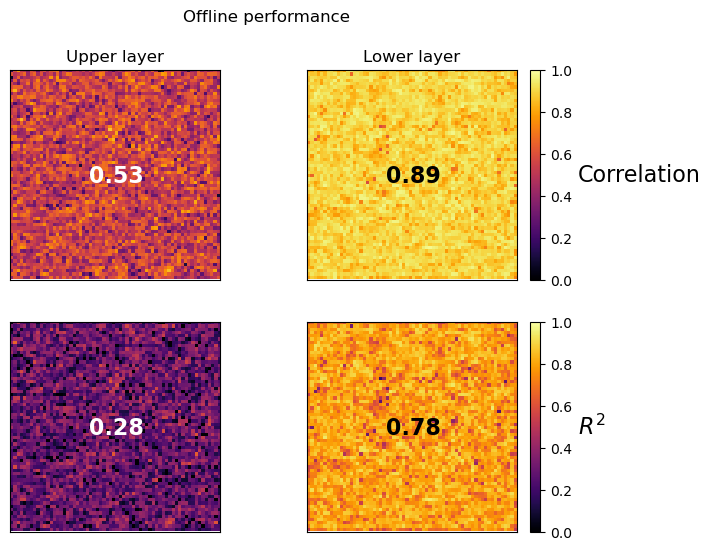

In [15]:
plt.figure(figsize=(7.6,6)).suptitle("Offline performance")

for z in [0,1]:
    plt.subplot(2,2,z+1,title=f"{['Upper','Lower'][z]} layer")
    imshow(preds1.q_subgrid_forcing_spatial_correlation.isel(lev=z))
    if z: colorbar("Correlation")
    
for z in [0,1]:
    plt.subplot(2,2,z+3)
    imshow(preds1.q_subgrid_forcing_spatial_skill.isel(lev=z))
    if z: colorbar("$R^2$")

We can improve these offline metrics by training our FCNN on more datasets. Below, we feed another dataset into each model, extract the inputs and targets from the dataset, and normalize by calling `fit()` which also then initiates a training session on the dataset.

In [ ]:
training_ds2 = xr.open_zarr('/home/jovyan/datasets/eddy/op2/ds3').load()
for m in param.models:
    new_inputs = m.extract_inputs(training_ds2)
    new_targets = m.extract_targets(training_ds2)
    m.fit(new_inputs, new_targets, rescale=True)

In [9]:
preds2 = param.test_offline(test_ds)
preds2

<xarray.Dataset>
Dimensions:                                 (time: 87, lev: 2, y: 64, x: 64)
Coordinates:
  * lev                                     (lev) int64 1 2
  * time                                    (time) float64 0.0 0.0 ... 0.0 0.0
  * x                                       (x) float64 7.812e+03 ... 9.922e+05
  * y                                       (y) float64 7.812e+03 ... 9.922e+05
Data variables: (12/14)
    q_subgrid_forcing                       (time, lev, y, x) float64 5.552e-...
    q_subgrid_forcing_predictions           (time, lev, y, x) float64 -8.356e...
    q_subgrid_forcing_spatial_mse           (lev, y, x) float64 6.78e-24 ... ...
    q_subgrid_forcing_temporal_mse          (time, lev) float64 4.417e-28 ......
    q_subgrid_forcing_mse                   (lev) float64 4.447e-24 7.325e-28
    q_subgrid_forcing_spatial_skill         (lev, y, x) float64 0.4654 ... 0....
    ...                                      ...
    q_subgrid_forcing_spatial_correlation   (lev, y, x) float64 0.7191 ... 0....
    q_subgrid_forcing_temporal_correlation  (time, lev) float64 0.007727 ... ...
    q_subgrid_forcing_correlation           (lev) float64 0.8257 0.9303
    correlation                             (lev) float64 0.8257 0.9303
    mse                                     (lev) float64 4.447e-24 7.325e-28
    skill                                   (lev) float64 0.6816 0.8652
Attributes: (12/23)
    pyqg:L:          1000000.0
    pyqg:M:          4096
    pyqg:W:          1000000.0
    pyqg:beta:       1.5e-11
    pyqg:del2:       0.8
    pyqg:delta:      0.25
    ...              ...
    pyqg:tavestart:  315360000.0
    pyqg:tc:         0
    pyqg:tmax:       1576800000.0
    pyqg:twrite:     1000.0
    reference:       https://pyqg.readthedocs.io/en/latest/index.html
    title:           pyqg: Python Quasigeostrophic Model

0.8199398019760309
0.9247365746800145
0.665754783534944
0.8495985600381821


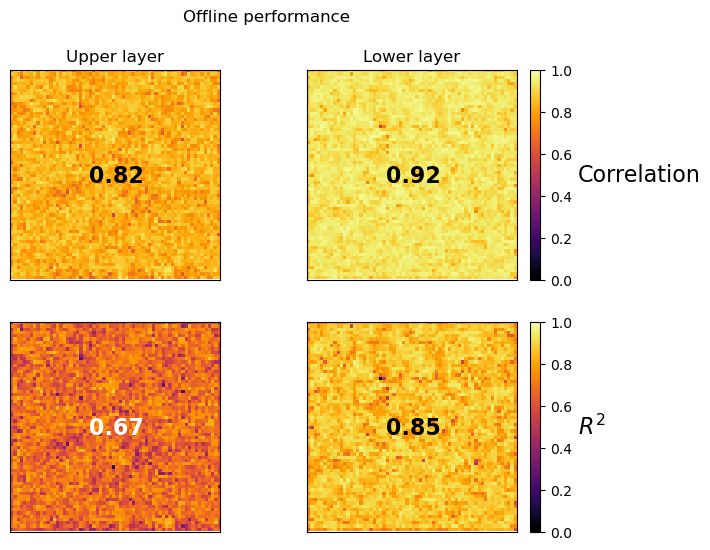

In [10]:
plt.figure(figsize=(7.6,6)).suptitle("Offline performance")

for z in [0,1]:
    plt.subplot(2,2,z+1,title=f"{['Upper','Lower'][z]} layer")
    imshow(preds2.q_subgrid_forcing_spatial_correlation.isel(lev=z))
    if z: colorbar("Correlation")
    
for z in [0,1]:
    plt.subplot(2,2,z+3)
    imshow(preds2.q_subgrid_forcing_spatial_skill.isel(lev=z))
    if z: colorbar("$R^2$")

We then save our newly trained models to the model directory path for our parameterization in order to keep the updated state of the models.

In [7]:
param.models[0].save('/home/jovyan/models/fcnn_qu_to_Sq2/models/0')
param.models[1].save('/home/jovyan/models/fcnn_qu_to_Sq2/models/1')

We can then reload the FCNN parameterization in future use cases by instantiating a new `FCNNParameterization` instance and passing in the directory path at which the parameterization is saved, as follows:

In [11]:
param = FCNNParameterization('/home/jovyan/models/fcnn_qu_to_Sq2')